# Modelo de predicción de éxito de las startups

**PARTE 2: SELECCIÓN DE VARIABLES Y CREACIÓN DE MODELOS**

## 1. Importación de librerías

**Librerías generales**

In [1]:
import os
import pandas as pd
import numpy as np
import itertools

**Librerías para gráficos**

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

**Librerías para construcción de modelos**

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, 
                             precision_score, recall_score, f1_score, accuracy_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

**Configuración**

In [4]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

## 2. Importación de datos

Importamos los datos de los dos ficheros depurados que vamos a probar:

- **startups_depurado_frequency**: variables categóricas recodificadas con su frecuencia relativa
- **startups_depurado_propsuccess**: variables categóricas recodificadas con su proporción de casos *success*

In [5]:
# Rutas de los ficheros
current_path = os.getcwd() # obtener la ruta donde se guarda este cuaderno
dataset_freq_path = current_path + '/startups_depurado_frequency.csv' # Fichero depurado: Frecuency Encoder
dataset_prop_path = current_path + '/startups_depurado_propsuccess.csv' # Fichero depurado: Proportion Success Encoder

# Lectura de los ficheros
df_startups_freq = pd.read_csv(dataset_freq_path, na_values=['none','None'])
df_startups_prop = pd.read_csv(dataset_prop_path, na_values=['none','None'])

In [6]:
len(df_startups_freq.columns)

111

In [7]:
len(df_startups_prop.columns)

111

## 3. Feature selection

Hacemos la selección de variables mediante el cálculo individual del AUC. Probaremos distintos modelos cambiando el punto de corte *threshold*.

**NOTA:** He ejecutado el código para los dos ficheros y las variables correlacionadas son las mismas, por lo tanto las elimino en los dos ficheros

**POSIBLES VARIABLES CONFLICTIVAS**

En general, todas las variables relacionadas con la experiencia de la empresa no las podemos saber a priori si queremos predecir el éxito/fracaso de las empresas en el momento de la creación. Es información que no vamos a poder tener con las nuevas observaciones.

- **age_years**: directamente relacionada con la variable objetivo (*Success* si la empresa sigue en activo a los X años, *Failed* si cierra antes de X años)
- **fundation_year**: mismo motivo
- **has_team_size_grown**: ha aumentado el tamaño del equipo. Info que a priori no podemos saber.
- **number_repeat_investors**: inversores que repiten. Info que a priori no podemos saber.
- **avg_size_companies_worked_for_past**: tampoco podemos saberlo en el inicio de la empresa
- **breadth_experience_across_verticals**
- **experience_fortune_100_organizations**
- **experience_fortune_500_organizations**
- **experience_fortune_1000_organizations**
- **company_awards**: si tiene premios es porque ha tenido éxito
- **employees_per_year_existence**: los años de existencia no los podemos conocer
- **survival_through_recession**
- **avg_time_to_investment**: a priori no podemos saber.
- **renown_score**: puntuación de renombre. Si tiene renombre es porque ha tenido éxito

Tengo más dudas de estas:
- **days_since_last_funding_date**
- **days_since_est_funding_date**
- **exposure_across_globe**

In [8]:
# Eliminamos variables conflictivas de ambos ficheros
vars_conflict = ["age_years", "fundation_year", "has_team_size_grown", "number_repeat_investors", "avg_size_companies_worked_for_past", "breadth_experience_across_verticals", "experience_fortune_100_organizations", "experience_fortune_500_organizations",
                 "experience_fortune_1000_organizations", "company_awards", "employees_per_year_existence", "survival_through_recession", "avg_time_to_investment", "renown_score", "exposure_across_globe", "days_since_last_funding_date", "days_since_est_funding_date"]

df_noconflict_freq = df_startups_freq.drop(vars_conflict, axis=1)  # fichero STARTUP_FREQUENCY
df_noconflict_prop = df_startups_prop.drop(vars_conflict, axis=1)  # fichero STARTUP_PROPORTION

### 3.1. Estudio de correlaciones

Sacamos un gráfico de correlaciones de las variables numéricas para tratar de eliminar variables que estén muy correlacionadas, ya que aportan información redundante.

#### 3.1.1. Fichero STARTUP_FREQUENCY

In [9]:
df_numeric = df_noconflict_freq.select_dtypes(include=["float64"]) # selecciono numericas
corr_df = df_numeric.corr()

In [10]:
corr_df # matriz de correlaciones

status  internet_score  \
status                                           1.000000        0.202803   
internet_score                                   0.202803        1.000000   
count_employee                                   0.071115        0.139861   
last_funding_amount                             -0.025432        0.067705   
number_investors_seed                            0.131532        0.114626   
number_investors_angel_VC                        0.049643       -0.063713   
number_cofounders                                0.205835        0.089144   
number_advisors                                  0.188963        0.039660   
team_size_senior_lead                            0.255690        0.123083   
team_size_all_employees                          0.036745        0.204459   
years_education                                  0.027094       -0.022166   
renowned_professional_circle                     0.140332        0.091063   
number_recognitions_for_founders_cofounders      0.153254        0.081916   
skills_score                                    -0.025790        0.024571   
google_page_rank_company_web                    -0.194879       -0.242407   
industry_trend_investing                         0.025436       -0.003328   
number_direct_competitors                        0.039833       -0.028976   
last_round_fundind_millionUSD                    0.013187        0.070292   
months_to_1st_investment                         0.076327       -0.005395   
perc_skill_entrepreneur                          0.063521        0.020376   
perc_skill_operations                           -0.036708       -0.084150   
perc_skill_engineering                           0.079733       -0.004266   
perc_skill_marketing                             0.032886        0.087828   
perc_skill_leadership                            0.063092       -0.037954   
perc_skill_datascience                           0.169279        0.031580   
perc_skill_business_strategy                    -0.065240       -0.050652   
perc_skill_product_manag                        -0.054518       -0.006236   
perc_skill_sales                                 0.009310       -0.079295   
perc_skill_domain                               -0.041169       -0.121623   
perc_skill_law                                   0.038897       -0.040585   
perc_skill_consulting                            0.058681       -0.005239   
perc_skill_finance                               0.003311       -0.052541   
perc_skill_investment                           -0.003900        0.005861   
industry                                         0.012164       -0.038585   
focus_functions                                  0.100775        0.092437   
country                                          0.021442       -0.002080   
continent                                        0.043552       -0.018571   
presence_angel_venture_fund                      0.102967        0.037925   
number_sales_support_material                    0.267919       -0.048605   
worked_top_company                               0.024288        0.048503   
part_of_startups_past                            0.114789        0.011491   
part_of_success_startups_past                    0.161857        0.025298   
partner_big5_consulting                          0.053713        0.022892   
consulting_experience                            0.305352        0.086462   
product_or_service_company                       0.036030       -0.006956   
catering_product_service_across_verticals        0.204340        0.059634   
focus_private_or_public_data                    -0.053657       -0.050467   
focus_consumer_data                             -0.071792        0.071789   
focus_structured_unstructured_data               0.200132        0.028617   
subscription_based                               0.169877        0.056974   
cloud_or_platform_based                         -0.188696        0.027429   
local_or_global_player                         

In [11]:
corr_df_abs = corr_df.abs()  # matriz de correlaciones en valor absoluto
upper = corr_df_abs.where(np.triu(np.ones(corr_df_abs.shape), k=1).astype(np.bool))  # triángulo superior de la matriz
vars_to_drop = [c for c in upper.columns if any(upper[c] > 0.75)]  # variables con correlación >0.75

In [12]:
vars_to_drop

['last_round_fundind_millionUSD',
 'continent',
 'part_of_success_startups_past',
 'controversial_history_founder_cofounder',
 'technical_skills_analyse_unstructured_data',
 'solutions_offered']

**Variables correlacionadas**:

- last_round_fundind_millionUSD:
    - last_funding_amount                                0.795699
- continent:
    - country                                            0.966224
- part_of_success_startups_past:
    - part_of_startups_past                              0.841086
- controversial_history_founder_cofounder:
    - proprietary_patent_position                        0.716158
    - hyper_localisation                                 0.719162
    - time_market_service_product                        0.733871
    - difficulty_obtain_workforce                        0.750313
    - legal_risk_intell_property                         0.760663
    - disruptiveness_technology                          0.775242
    - team_composition_score                             0.847335
    - solutions_offered                                  0.905945
    - pricing_strategy                                   0.916762
    - technical_skills_analyse_unstructured_data         0.919250
- technical_skills_analyse_unstructured_data:
    - highest_education                                  0.713242
    - avg_years_experience for founder and co founder    0.729571
    - proprietary_patent_position                        0.746133
    - legal_risk_intell_property                         0.752223
    - long_term_relation_other_founders                  0.753278
    - time_market_service_product                        0.755792
    - hyper_localisation                                 0.756245
    - disruptiveness_technology                          0.791730
    - difficulty_obtain_workforce                        0.799461
    - team_composition_score                             0.885346
    - controversial_history_founder_cofounder            0.919250
    - pricing_strategy                                   0.965417
    - solutions_offered                                  0.967035
- solutions_offered:
    - avg_years_experience for founder and co founder    0.722453
    - highest_education                                  0.723791
    - hyper_localisation                                 0.742106
    - time_market_service_product                        0.765559
    - proprietary_patent_position                        0.766714
    - legal_risk_intell_property                         0.771843
    - long_term_relation_other_founders                  0.773206
    - disruptiveness_technology                          0.784060
    - difficulty_obtain_workforce                        0.800028
    - team_composition_score                             0.890685
    - controversial_history_founder_cofounder            0.905945
    - technical_skills_analyse_unstructured_data         0.967035
    - pricing_strategy                                   0.983764

In [13]:
# Eliminamos variables correlacionadas del fichero STARTUP_FREQUENCY
vars_to_drop_def = ["last_round_fundind_millionUSD", "continent", "part_of_success_startups_past", "technical_skills_analyse_unstructured_data",
                    "pricing_strategy", "controversial_history_founder_cofounder", "team_composition_score", "difficulty_obtain_workforce",
                    "disruptiveness_technology", "long_term_relation_other_founders", "legal_risk_intell_property", "proprietary_patent_position",
                    "time_market_service_product", "hyper_localisation", "highest_education", "avg_years_experience for founder and co founder",
                    "client_reputation", "top_management_similarity", "solutions_offered", "relevance_experience_venture", "google_page_rank_company_web", "invested_through_global_incubation_competitions"]

df_corr_elim_freq = df_noconflict_freq.drop(vars_to_drop_def, axis=1)
df_corr_elim_freq.shape

(472, 72)

In [14]:
input_cols_freq = df_corr_elim_freq.select_dtypes(include=["float64"]).columns.drop('status') # selecciono numericas

#### 3.1.2. Fichero STARTUP_PROPORTION

In [15]:
df_numeric = df_noconflict_prop.select_dtypes(include=["float64"]) # selecciono numericas
corr_df = df_numeric.corr()

In [16]:
corr_df # matriz de correlaciones

status  internet_score  \
status                                           1.000000        0.202803   
internet_score                                   0.202803        1.000000   
count_employee                                   0.071115        0.139861   
last_funding_amount                             -0.025432        0.067705   
number_investors_seed                            0.131532        0.114626   
number_investors_angel_VC                        0.049643       -0.063713   
number_cofounders                                0.205835        0.089144   
number_advisors                                  0.188963        0.039660   
team_size_senior_lead                            0.255690        0.123083   
team_size_all_employees                          0.036745        0.204459   
years_education                                  0.027094       -0.022166   
renowned_professional_circle                     0.140332        0.091063   
number_recognitions_for_founders_cofounders      0.153254        0.081916   
skills_score                                    -0.025790        0.024571   
google_page_rank_company_web                    -0.194879       -0.242407   
industry_trend_investing                         0.025436       -0.003328   
number_direct_competitors                        0.039833       -0.028976   
last_round_fundind_millionUSD                    0.013187        0.070292   
months_to_1st_investment                         0.076327       -0.005395   
perc_skill_entrepreneur                          0.063521        0.020376   
perc_skill_operations                           -0.036708       -0.084150   
perc_skill_engineering                           0.079733       -0.004266   
perc_skill_marketing                             0.032886        0.087828   
perc_skill_leadership                            0.063092       -0.037954   
perc_skill_datascience                           0.169279        0.031580   
perc_skill_business_strategy                    -0.065240       -0.050652   
perc_skill_product_manag                        -0.054518       -0.006236   
perc_skill_sales                                 0.009310       -0.079295   
perc_skill_domain                               -0.041169       -0.121623   
perc_skill_law                                   0.038897       -0.040585   
perc_skill_consulting                            0.058681       -0.005239   
perc_skill_finance                               0.003311       -0.052541   
perc_skill_investment                           -0.003900        0.005861   
industry                                         0.115450       -0.020005   
focus_functions                                  0.157066        0.102823   
country                                          0.051657       -0.005055   
continent                                        0.082191       -0.021006   
presence_angel_venture_fund                      0.142657        0.057951   
number_sales_support_material                    0.465757        0.076252   
worked_top_company                               0.036021        0.052279   
part_of_startups_past                            0.127295        0.018592   
part_of_success_startups_past                    0.191643        0.049676   
partner_big5_consulting                          0.063496        0.027167   
consulting_experience                            0.304666        0.063277   
product_or_service_company                       0.042346       -0.007817   
catering_product_service_across_verticals        0.360891        0.117526   
focus_private_or_public_data                     0.297465        0.039052   
focus_consumer_data                              0.088373        0.067462   
focus_structured_unstructured_data               0.416470        0.071971   
subscription_based                               0.162540        0.054927   
cloud_or_platform_based                         -0.178484        0.025434   
local_or_global_player                         

In [17]:
corr_df_abs = corr_df.abs()  # matriz de correlaciones en valor absoluto
upper = corr_df_abs.where(np.triu(np.ones(corr_df_abs.shape), k=1).astype(np.bool))  # triángulo superior de la matriz
vars_to_drop = [c for c in upper.columns if any(upper[c] > 0.75)]  # variables con correlación >0.75

In [18]:
vars_to_drop

['last_round_fundind_millionUSD',
 'continent',
 'part_of_success_startups_past',
 'pricing_strategy',
 'time_market_service_product',
 'long_term_relation_other_founders',
 'proprietary_patent_position',
 'controversial_history_founder_cofounder',
 'legal_risk_intell_property',
 'technical_skills_analyse_unstructured_data',
 'solutions_offered',
 'disruptiveness_technology']

**Variables correlacionadas**:

- last_round_fundind_millionUSD: 
    - last_funding_amount (0.79)
- continent: 
    - country (0.96)
- part_of_success_startups_past: 
    - part_of_startups_past (0.84)
- pricing_strategy:
    - avg_years_experience for founder and co founder    0.722795
    - highest_education                                  0.724434
    - hyper_localisation                                 0.748862
    - legal_risk_intell_property                         0.761779
    - proprietary_patent_position                        0.762992
    - long_term_relation_other_founders                  0.763557
    - time_market_service_product                        0.776864
    - disruptiveness_technology                          0.787571
    - difficulty_obtain_workforce                        0.797210
    - team_composition_score                             0.910380
    - controversial_history_founder_cofounder            0.916762
    - technical_skills_analyse_unstructured_data         0.965417
    - solutions_offered                                  0.983764
- time_market_service_product:
    - team_composition_score                             0.711910
    - controversial_history_founder_cofounder            0.733871
    - technical_skills_analyse_unstructured_data         0.755792
    - solutions_offered                                  0.765559
    - pricing_strategy                                   0.776864
- long_term_relation_other_founders:
    - team_composition_score                             0.728845
    - technical_skills_analyse_unstructured_data         0.753278
    - pricing_strategy                                   0.763557
    - solutions_offered                                  0.773206
- proprietary_patent_position:
    - controversial_history_founder_cofounder            0.716158
    - team_composition_score                             0.733217
    - technical_skills_analyse_unstructured_data         0.746133
    - pricing_strategy                                   0.762992
    - solutions_offered                                  0.766714
- controversial_history_founder_cofounder:
    - proprietary_patent_position                        0.716158
    - hyper_localisation                                 0.719162
    - time_market_service_product                        0.733871
    - difficulty_obtain_workforce                        0.750313
    - legal_risk_intell_property                         0.760663
    - disruptiveness_technology                          0.775242
    - team_composition_score                             0.847335
    - solutions_offered                                  0.905945
    - pricing_strategy                                   0.916762
    - technical_skills_analyse_unstructured_data         0.919250
- legal_risk_intell_property:
    - team_composition_score                             0.701082
    - technical_skills_analyse_unstructured_data         0.752223
    - controversial_history_founder_cofounder            0.760663
    - pricing_strategy                                   0.761779
    - solutions_offered                                  0.771843
- technical_skills_analyse_unstructured_data:
    - highest_education                                  0.713242
    - avg_years_experience for founder and co founder    0.729571
    - proprietary_patent_position                        0.746133
    - legal_risk_intell_property                         0.752223
    - long_term_relation_other_founders                  0.753278
    - time_market_service_product                        0.755792
    - hyper_localisation                                 0.756245
    - disruptiveness_technology                          0.791730
    - difficulty_obtain_workforce                        0.799461
    - team_composition_score                             0.885346
    - controversial_history_founder_cofounder            0.919250
    - pricing_strategy                                   0.965417
    - solutions_offered                                  0.967035
- solutions_offered:
    - avg_years_experience for founder and co founder    0.722453
    - highest_education                                  0.723791
    - hyper_localisation                                 0.742106
    - time_market_service_product                        0.765559
    - proprietary_patent_position                        0.766714
    - legal_risk_intell_property                         0.771843
    - long_term_relation_other_founders                  0.773206
    - disruptiveness_technology                          0.784060
    - difficulty_obtain_workforce                        0.800028
    - team_composition_score                             0.890685
    - controversial_history_founder_cofounder            0.905945
    - technical_skills_analyse_unstructured_data         0.967035
    - pricing_strategy                                   0.983764
- disruptiveness_technology:
    - team_composition_score                             0.711677
    - controversial_history_founder_cofounder            0.775242
    - solutions_offered                                  0.784060
    - pricing_strategy                                   0.787571
    - technical_skills_analyse_unstructured_data         0.791730

In [19]:
# Eliminamos variables correlacionadas del fichero STARTUP_PROPORTION
vars_to_drop_def = ["last_round_fundind_millionUSD", "continent", "part_of_success_startups_past", "solutions_offered",
                    "technical_skills_analyse_unstructured_data", "controversial_history_founder_cofounder", "team_composition_score",
                    "difficulty_obtain_workforce", "disruptiveness_technology", "time_market_service_product",
                    "long_term_relation_other_founders", "proprietary_patent_position", "legal_risk_intell_property",
                    "hyper_localisation", "highest_education", "avg_years_experience for founder and co founder",
                    "pricing_strategy", "invested_through_global_incubation_competitions", "experience_selling_building_products", "google_page_rank_company_web", "client_reputation"]

df_corr_elim_prop = df_noconflict_prop.drop(vars_to_drop_def, axis=1)
df_corr_elim_prop.shape

(472, 73)

In [20]:
input_cols_prop = df_corr_elim_prop.select_dtypes(include=["float64"]).columns.drop('status') # selecciono numericas

### 3.2. Selección de variables

La selección de variables es diferente en cada dataset

**Selección mediante AUC**

In [21]:
def get_auc(df, score_col, label_col): 
    
    """
    Función que calcula el AUC de una variable con respecto a la variable objetivo
    
    - df: dataframe que contiene la variable input y label
    - score_col: columna de la variable input
    - label_col: columna de la variable objetivo
    
    """
    
    #1. Compruebo dirección de la variable input con respecto a la objetivo (ajuste para que no salgan AUC negativos)
    
    avg_df = df.groupby(label_col)[score_col].mean() #media de la variable input para label=success y label=failure
    avg_failed = avg_df.values[0] #media de la variable input para label=failed
    avg_success = avg_df.values[1] #media de la variable input para label=success
    
    if avg_failed > avg_success: #si la media de la variable input para label=failed es superior que para label=success 

        df[score_col] = -1.0*df[score_col] #paso la variable input a negativa
        
    else: #si la media de la variable input para label=success es superior que para label=failed

        df #dejo la variable input igual
    
    #2. Paso las columnas label e input a array para poder calcular AUC

    x = df[score_col].to_numpy() 
    y = df[label_col].to_numpy()

    #3. Calculo AUC de la variable input con respecto a la variable objetivo
    
    auc = roc_auc_score(y, x) 

    return auc

In [22]:
def feature_selection_auc(df, threshold, cols_to_filter, label_col = 'status'): 

    """
    Función que aplica get_auc sobre todas las variables input y selecciona aquellas con un AUC superior
    
    - df: dataframe que contiene las variables input y label
    - threshold: AUC a partir del cuál me quedo con una variable 
    - cols_to_filter: columnas sobre las que queremos calcular el AUC
    - label_col: columna de la variable objetivo
    """
    
    #1. Calculo AUC de todas las variables input y las guardo en una tupla ordenada de mayor a menor AUC
    
    auc_results = [(f, get_auc(df, score_col=f, label_col=label_col)) for f in cols_to_filter] 
    auc_results = sorted(auc_results, key=lambda tup: tup[1], reverse=True)

    #2. Imprimo por pantalla los resultados
    
    for (f, r) in auc_results:
            print ("[Info] " + f + ": " + str(r))
            
            
    #3. Me quedo con aquellas variables cuyo AUC sea superior al threshold que indiquemos
    
    auc_greater = [list(group) for val, group in itertools.groupby(auc_results, lambda x: x[1] > threshold) if val]
 
    vars_selected = [var for var, auc in auc_greater[0]]
    
    return vars_selected

**NOTA**: Hay que jugar con el punto de corte hasta llegar al número de variables independientes deseado (mínimo 0.5)

## 4. Prueba de diferentes modelos

### Modelo 1: Transformación FREQUENCY, AUC > 0.5. RF

Seleccionamos variables con un AUC superior a 0.5, con el dataset de frecuencias:

In [23]:
vars_selected_freq1 = feature_selection_auc(df_corr_elim_freq, 0.5, input_cols_freq, label_col = 'status') 

[Info] relevance_education_venture: 0.7441150485913419
[Info] local_or_global_player: 0.7277706881319328
[Info] gartner_hype_cycle_stage: 0.7197113968783744
[Info] renowned_professional_circle: 0.7067733385687641
[Info] degree_tier1_tier2_university: 0.6960930597820753
[Info] team_size_senior_lead: 0.6941199568076961
[Info] big_data_business: 0.6909983312064396
[Info] B2C_or_B2B: 0.6855502110533032
[Info] focus_structured_unstructured_data: 0.6720329832139
[Info] aggregator_or_market_place: 0.6571807205261608
[Info] employee_benefits_salary_structures: 0.6538235005399038
[Info] consulting_experience: 0.6406792971434181
[Info] number_cofounders: 0.6267105133994306
[Info] predictive_analytics_business: 0.624305487385884
[Info] number_sales_support_material: 0.6238833807794247
[Info] industry_trend_investing: 0.6139000687150289
[Info] barriers_entry_competitors: 0.6058211445960537
[Info] perc_skill_investment: 0.5956611367429075
[Info] internet_score: 0.5903504466476882
[Info] perc_skill_

In [24]:
len(vars_selected_freq1) #se queda con 55 variables de las 72 que teníamos tras eliminar correladas

55

Creamos el dataset para el primer modelo, con las variables input seleccionadas, la variable target y la identificadora de la empresa

In [25]:
df_model1 = df_startups_freq[['company_name'] + ['status'] + vars_selected_freq1]

Dividimos en train y test: decidimos entrenar con el 70% de los datos y validar con el 30% restante

In [26]:
train1, test1 = train_test_split(df_model1,
                                 train_size=0.7,
                                 test_size=0.3)

Aplicamos el modelo con los datos de train (parámetro class_weight para balancear)

In [27]:
model1_rf = RandomForestClassifier(class_weight='balanced')  # class 1: 64.6%, class 0: 35.4%

In [28]:
model1 = model1_rf.fit(train1[vars_selected_freq1],
                       train1['status'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sacamos importancia de variables del modelo entrenado:

In [29]:
feat_importances_model1 = pd.DataFrame(model1.feature_importances_,
                                       index=vars_selected_freq1,
                                       columns=['importance']).sort_values('importance', ascending=False)

In [30]:
feat_importances_model1

importance
relevance_education_venture                    0.101223
internet_score                                 0.069116
focus_structured_unstructured_data             0.061124
number_recognitions_for_founders_cofounders    0.059312
industry_trend_investing                       0.057662
local_or_global_player                         0.045761
big_data_business                              0.035128
number_sales_support_material                  0.033690
employee_benefits_salary_structures            0.031885
skills_score                                   0.030807
focus_consumer_data                            0.030665
renowned_professional_circle                   0.028198
perc_skill_datascience                         0.026255
perc_skill_product_manag                       0.024454
crowdsourcing_business                         0.023632
specialization_highest_education               0.019484
top_forums_talking_about_company               0.018698
perc_skill_business_strategy                   0.018663
perc_skill_engineering                         0.018645
number_cofounders                              0.016903
team_size_senior_lead                          0.016288
perc_skill_domain                              0.014974
cloud_or_platform_based                        0.014355
gartner_hype_cycle_stage                       0.014149
prescriptive_analytics_business                0.013979
linear_nonlinear_business                      0.012592
B2C_or_B2B                                     0.012532
presence_angel_venture_fund                    0.011987
last_funding_amount                            0.011478
number_investors_seed                          0.009861
consulting_experience                          0.009721
capital_intensive                              0.008949
perc_skill_operations                          0.008368
subscription_based                             0.007577
years_education                                0.007486
aggregator_or_market_place                     0.007172
perc_skill_investment                          0.006800
ML_business                                    0.006254
perc_skill_entrepreneur                        0.005826
cross_channel_analytics_or_marketing           0.005733
predictive_analytics_business                  0.005705
barriers_entry_competitors                     0.005411
number_advisors                                0.004929
degree_tier1_tier2_university                  0.004637
focus_private_or_public_data                   0.004358
product_or_service_company                     0.004114
country                                        0.003425
owns_data                                      0.003242
part_of_startups_past                          0.002690
industry                                       0.001501
partner_big5_consulting                        0.001324
speech_analytics_business                      0.000795
worked_top_company                             0.000485
crowdfunding_business                          0.000000
online_or_offline_business                     0.000000

**Evaluación del modelo: Curva ROC y AUC**

In [31]:
test = test1
model = model1
feature_columns = vars_selected_freq1

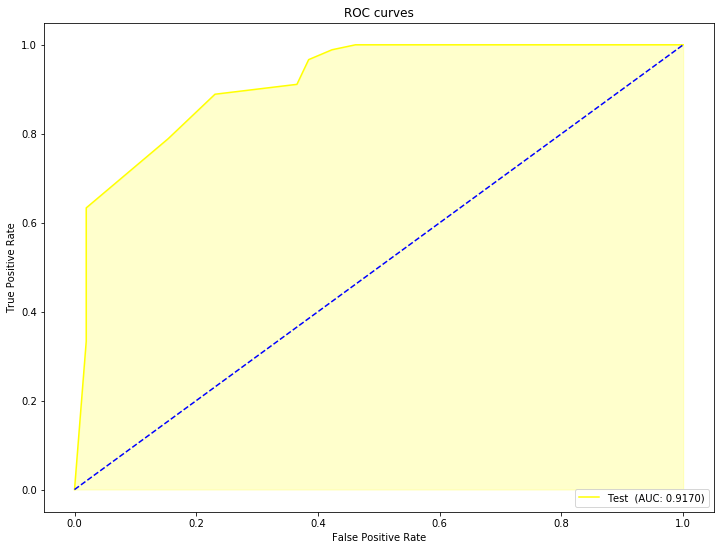

In [32]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:, 1], pos_label=1.0)
df_roc_test = pd.DataFrame({"fpr": fpr, "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [33]:
auc_test_model1 = auc_test
auc_test

0.9169871794871794

In [34]:
auc_train_model1 = roc_auc_score(train1['status'],
                                 model.predict_proba(train1[vars_selected_freq1])[:, 1])
auc_train_model1

0.9999393326592517

In [35]:
accuracy_model1 = accuracy_score(test['status'], model.predict(test[feature_columns]))
accuracy_model1

0.8098591549295775

**COMENTARIO**: El AUC en train es demasiado alto (prácticamente 1), y hay algo de overfitting (en test el AUC es inferior). Sin embargo, no podemos decir que haya demasiado overfitting, ya que prácticamente son igual de altos. 

### Modelo 2: Transformación PROPORTION, AUC > 0.5. RF

Ahora seleccionamos variables con un AUC superior a 0.5, con el dataset de proporción objetivo:

In [36]:
vars_selected_prop2 = feature_selection_auc(df_corr_elim_prop, 0.5, input_cols_prop, label_col = 'status') 

[Info] relevance_experience_venture: 0.7600274860115834
[Info] relevance_education_venture: 0.7441150485913419
[Info] focus_structured_unstructured_data: 0.7396682045744576
[Info] local_or_global_player: 0.7277706881319328
[Info] big_data_business: 0.7209384509669187
[Info] top_management_similarity: 0.7135761264356532
[Info] renowned_professional_circle: 0.7067733385687641
[Info] degree_tier1_tier2_university: 0.6960930597820753
[Info] team_size_senior_lead: 0.6941199568076961
[Info] number_sales_support_material: 0.6896142141945617
[Info] B2C_or_B2B: 0.6855502110533032
[Info] catering_product_service_across_verticals: 0.6815058407774615
[Info] top_forums_talking_about_company: 0.6718759202905664
[Info] gartner_hype_cycle_stage: 0.6636399332482575
[Info] aggregator_or_market_place: 0.6571807205261608
[Info] focus_private_or_public_data: 0.6569254932757436
[Info] focus_functions: 0.6539020320015706
[Info] employee_benefits_salary_structures: 0.6538235005399038
[Info] specialization_hig

In [37]:
len(vars_selected_prop2) #se queda con 59 variables de las 73 que teníamos tras eliminar correladas

59

In [38]:
df_model2 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop2]

In [39]:
train2, test2 = train_test_split(df_model2,
                                 train_size=0.7,
                                 test_size=0.3)

In [40]:
model2_rf = RandomForestClassifier(class_weight='balanced')  # class 1: 64.6%, class 0: 35.4%

In [41]:
model2 = model2_rf.fit(train2[vars_selected_prop2],
                       train2['status'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [42]:
feat_importances_model2 = pd.DataFrame(model2.feature_importances_,
                                       index=vars_selected_prop2,
                                       columns=['importance']).sort_values('importance', ascending=False)

In [43]:
feat_importances_model2

importance
relevance_education_venture                    0.109400
local_or_global_player                         0.072542
B2C_or_B2B                                     0.062155
number_sales_support_material                  0.053484
focus_structured_unstructured_data             0.047890
internet_score                                 0.046199
specialization_highest_education               0.042327
relevance_experience_venture                   0.032540
renowned_professional_circle                   0.030813
number_recognitions_for_founders_cofounders    0.030693
big_data_business                              0.028098
catering_product_service_across_verticals      0.026091
perc_skill_investment                          0.023660
employee_benefits_salary_structures            0.022048
top_forums_talking_about_company               0.020888
perc_skill_datascience                         0.020135
skills_score                                   0.019621
focus_private_or_public_data                   0.019312
industry                                       0.017998
perc_skill_domain                              0.016615
focus_functions                                0.015831
last_funding_amount                            0.015159
gartner_hype_cycle_stage                       0.015133
number_investors_seed                          0.013664
degree_tier1_tier2_university                  0.013178
perc_skill_engineering                         0.012419
top_management_similarity                      0.011534
perc_skill_product_manag                       0.009203
capital_intensive                              0.009166
cloud_or_platform_based                        0.008991
perc_skill_business_strategy                   0.008278
online_or_offline_business                     0.008056
industry_trend_investing                       0.007865
time_maturity_technology                       0.007360
prescriptive_analytics_business                0.007210
ML_business                                    0.006854
team_size_senior_lead                          0.006434
barriers_entry_competitors                     0.006325
linear_nonlinear_business                      0.006308
country                                        0.006085
number_advisors                                0.005631
perc_skill_entrepreneur                        0.005344
product_or_service_company                     0.005149
aggregator_or_market_place                     0.004866
years_education                                0.004854
crowdsourcing_business                         0.004801
partner_big5_consulting                        0.004240
perc_skill_operations                          0.004218
number_cofounders                              0.003980
worked_top_company                             0.003861
consulting_experience                          0.002989
owns_data                                      0.002904
predictive_analytics_business                  0.002618
presence_angel_venture_fund                    0.002340
subscription_based                             0.002173
speech_analytics_business                      0.002024
part_of_startups_past                          0.000449
crowdfunding_business                          0.000000
cross_channel_analytics_or_marketing           0.000000

**Evaluación del modelo: Curva ROC y AUC**

In [44]:
test = test2
model = model2
feature_columns = vars_selected_prop2

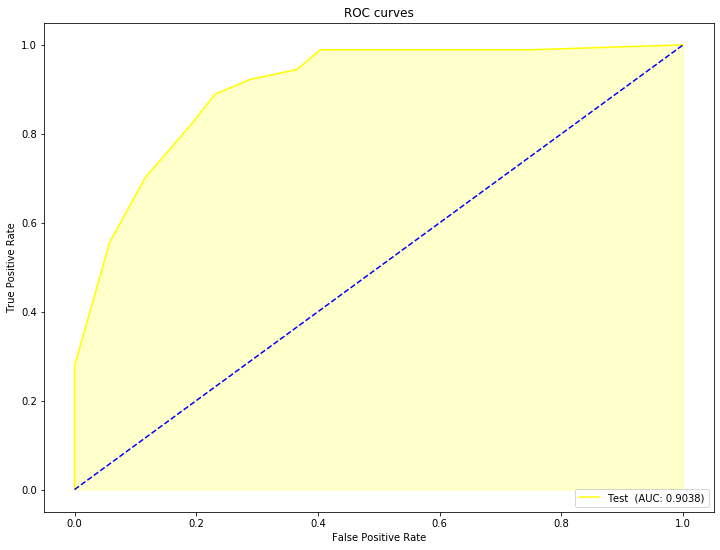

In [45]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:, 1],
                        pos_label=1.0
                        )
df_roc_test = pd.DataFrame({"fpr": fpr,
                            "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [46]:
auc_test_model2 = auc_test
auc_test

0.9038461538461539

In [47]:
auc_train_model2 = roc_auc_score(train2['status'],
                                 model.predict_proba(train2[feature_columns])[:, 1])
auc_train_model2

1.0

In [48]:
accuracy_model2 = accuracy_score(test['status'], model.predict(test[feature_columns]))
accuracy_model2

0.8450704225352113

**COMENTARIO**: Aquí el AUC en test aumenta un poco, y en train sigue igual que en el anterior modelo (prácticamente 1)

### Modelo 3: Transformación PROPORTION, AUC > 0.6. RF

Ahora, con el dataset de proporción objetivo, probamos a aumentar el threshold de AUC para introducir menos variables en el modelo (no es recomendable que tengamos casi el mismo número de variables que de observaciones en los datos de test)

In [49]:
vars_selected_prop3 = feature_selection_auc(df_corr_elim_prop, 0.6, input_cols_prop, label_col='status')

[Info] relevance_experience_venture: 0.7600274860115834
[Info] relevance_education_venture: 0.7441150485913419
[Info] focus_structured_unstructured_data: 0.7396682045744576
[Info] local_or_global_player: 0.7277706881319328
[Info] big_data_business: 0.7209384509669187
[Info] top_management_similarity: 0.7135761264356532
[Info] renowned_professional_circle: 0.7067733385687641
[Info] degree_tier1_tier2_university: 0.6960930597820753
[Info] team_size_senior_lead: 0.6941199568076961
[Info] number_sales_support_material: 0.6896142141945617
[Info] B2C_or_B2B: 0.6855502110533032
[Info] catering_product_service_across_verticals: 0.6815058407774615
[Info] top_forums_talking_about_company: 0.6718759202905664
[Info] gartner_hype_cycle_stage: 0.6636399332482575
[Info] aggregator_or_market_place: 0.6571807205261608
[Info] focus_private_or_public_data: 0.6569254932757436
[Info] focus_functions: 0.6539020320015706
[Info] employee_benefits_salary_structures: 0.6538235005399038
[Info] specialization_hig

In [50]:
len(vars_selected_prop3) #se queda con 24 variables

24

In [51]:
df_model3 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop3]

In [157]:
train3, test3 = train_test_split(df_model3,
                                 train_size=0.7,
                                 test_size=0.3)

In [53]:
model3_rf = RandomForestClassifier(class_weight='balanced')  # class 1: 64.6%, class 0: 35.4%

In [54]:
model3 = model3_rf.fit(train3[vars_selected_prop3],
                       train3['status'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [55]:
feat_importances_model3 = pd.DataFrame(model3.feature_importances_,
                                       index=vars_selected_prop3,
                                       columns=['importance']).sort_values('importance', ascending=False)

In [56]:
feat_importances_model3

importance
number_sales_support_material                0.156225
renowned_professional_circle                 0.082654
big_data_business                            0.073904
relevance_experience_venture                 0.069929
relevance_education_venture                  0.063389
specialization_highest_education             0.063349
focus_functions                              0.052155
focus_private_or_public_data                 0.050004
industry_trend_investing                     0.045539
gartner_hype_cycle_stage                     0.040867
focus_structured_unstructured_data           0.039065
catering_product_service_across_verticals    0.034147
aggregator_or_market_place                   0.028907
number_cofounders                            0.026243
degree_tier1_tier2_university                0.024732
team_size_senior_lead                        0.024458
top_forums_talking_about_company             0.022488
predictive_analytics_business                0.021546
local_or_global_player                       0.018081
employee_benefits_salary_structures          0.017799
B2C_or_B2B                                   0.015670
top_management_similarity                    0.011081
consulting_experience                        0.010411
barriers_entry_competitors                   0.007358

**Evaluación del modelo: Curva ROC y AUC**

In [57]:
test = test3
model = model3
feature_columns = vars_selected_prop3

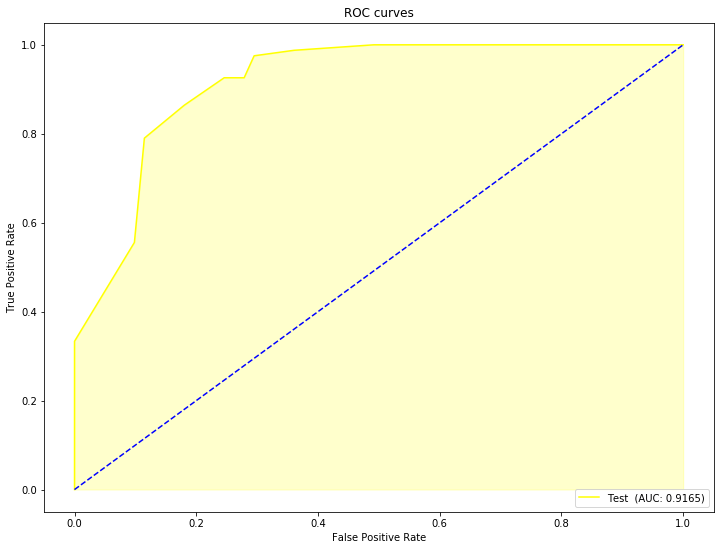

In [58]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:,1],
                        pos_label=1.0
                       )
df_roc_test = pd.DataFrame({"fpr":fpr, 
                            "tpr":tpr})

auc_test = roc_auc_score(test['status'], 
                         model.predict_proba(test[feature_columns])[:,1])

# ROC plotting
plt.figure(figsize=(12,9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"], "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0,1],[0,1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"], y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [59]:
auc_test_model3 = auc_test
auc_test_model3

0.9165148755312689

In [60]:
auc_train_model3 = roc_auc_score(train3['status'], 
                         model.predict_proba(train3[feature_columns])[:,1])
auc_train_model3

0.9996841307277629

In [61]:
accuracy_model3 = accuracy_score(test['status'], model.predict(test[feature_columns]))
accuracy_model3

0.852112676056338

**COMENTARIO**: Aquí tenemos un resultado similar al del modelo anterior. Sin embargo, hemos introducido casi la mitad de variables, por lo que este modelo es más recomendable

### Modelo 3_1: Transformación PROPORTION, AUC > 0.6. RF + Grid search Cross Validation

Una técnica para reducir el sobreajuste es la validación cruzada. Utilizamos GridSearchCV, que nos permite entrenar de forma automática distintos modelos, variando para cada uno de ellos el conjunto de entrenamiento seleccionado y los valores de los hiperparámetros.

Utilizamos el mismo dataset que en el modelo anterior (categóricas transformadas a proporción objetivo, filtrando variables por AUC>0.6): train3, test3

In [62]:
model3_1_rf = RandomForestClassifier(class_weight='balanced')

param_grid3_1 = {"n_estimators": [100, 200, 300, 500, 1000],  # hiperparámetros a probar (todas las combinaciones posibles)
                 "max_features": ["sqrt", 0.3, 0.6],
                 "max_depth": [None, 10, 15, 20, 30],
                 "min_samples_split": [2, 5, 10],
                 "n_jobs": [-1],
                 "class_weight": ["balanced"]
                 }

grid3_1 = GridSearchCV(estimator=model3_1_rf,
                       param_grid=param_grid3_1,
                       scoring="roc_auc",  # métrica de evaluación: AUC
                       cv=5,  # número de "folds": conjuntos de entrenamiento con los que se prueba cada combinación de parámetros
                       verbose=3)

In [63]:
model3_1 = grid3_1.fit(train3[vars_selected_prop3],
                       train3['status'])

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.954, total=   5.9s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.943, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.952, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.993, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.959, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.951, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.948, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.937, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.946, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.992, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.990, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.959, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.945, total=   1.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.938, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.930, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.931, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.992, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.950, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.952, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.940, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.938, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.944, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.931, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.993, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.958, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.944, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, 

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.953, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.944, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.925, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.989, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.990, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.962, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.945, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.949, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.938, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.950, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.990, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.960, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.956, total=   1.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.958, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.948, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.962, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV] 

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.941, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.993, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.962, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.949, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.944, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.937, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.934, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.990, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.995, total=   1.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.955, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.939, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.935, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV] 

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.940, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.933, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.992, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.952, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.963, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.960, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.942, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.957, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.954, total=   1.8s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.992, total=   2.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.961, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.952, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.947, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.945, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.949, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.994, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.993, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.959, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.939, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.944, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.938, total=   1.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.941, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.992, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.956, total=   1.9s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_job

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.960, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.942, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.934, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.940, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.932, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.992, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.955, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.930, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.957, total=   1.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.948, total=   1.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.956, total=   1.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.992, total=   1.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.989, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.958, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.948, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.932, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.933, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.956, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.993, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.965, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.962, total=   0.9s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.943, total=   1.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.942, total=   1.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.942, total=   1.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.938, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.993, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.964, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.948, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.953, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.940, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.941, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.995, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.996, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.957, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.936, total=   1.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.932, total=   1.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.933, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.953, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.990, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.957, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.941, total=   0.9s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.937, total=   0.8s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.949, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.949, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.992, total=   0.9s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.957, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.944, total=   1.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV] 

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.946, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.933, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.934, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.996, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.992, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.962, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.949, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.941, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.938, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.940, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.992, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.957, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  c

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.949, total=   1.6s


[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed: 16.1min finished


**Elección del mejor modelo**

Aquí se muestra un resumen de todos los modelos entrenados: el primero es el que tiene mayor media de AUC en los datos de validación (mean_test_score)

In [64]:
tabla = pd.DataFrame(model3_1.cv_results_).sort_values(by="mean_test_score", ascending=False)
tabla

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
136       0.362911      0.048290         0.110191        0.000717   
60        0.228455      0.029633         0.111014        0.000900   
139       1.299839      0.022532         0.311774        0.001189   
186       0.370743      0.047542         0.110912        0.000554   
183       0.771799      0.045605         0.210855        0.000854   
181       0.337454      0.024864         0.109648        0.000878   
4         1.328872      0.086689         0.355503        0.052843   
93        0.837674      0.070494         0.211943        0.001278   
151       0.399427      0.016774         0.110395        0.000536   
16        0.251505      0.049065         0.106610        0.001555   
45        0.265363      0.051521         0.111356        0.001210   
2         0.596998      0.038883         0.110347        0.001128   
109       1.350225      0.055116         0.332964        0.040532   
184       1.321220      0.008848         0.353447        0.051523   
47        0.464564      0.059571         0.129397        0.040774   
135       0.228975      0.017176         0.111541        0.000711   
1         0.348640      0.036214         0.109130        0.001588   
52        0.485703      0.030501         0.109867        0.000928   
48        0.870417      0.079666         0.212587        0.066093   
107       0.501983      0.054801         0.109713        0.000791   
51        0.421658      0.077851         0.111009        0.000978   
49        1.308450      0.081707         0.376394        0.051764   
92        0.496396      0.032010         0.129361        0.040425   
3         0.797900      0.022060         0.211500        0.001135   
94        1.393213      0.058228         0.335175        0.042711   
0         1.410440      2.167932         0.111402        0.001972   
19        1.373370      0.087312         0.374369        0.050595   
145       0.242936      0.021687         0.111633        0.001711   
137       0.566122      0.099398         0.109627        0.000338   
6         0.580230      0.185952         0.134245        0.043505   
106       0.332523      0.016507         0.110416        0.000408   
188       0.749237      0.019631         0.210809        0.001165   
187       0.504333      0.042407         0.109827        0.000655   
182       0.523201      0.036909         0.110352        0.000722   
90        0.227909      0.011528         0.111661        0.001434   
143       0.787668      0.037749         0.211324        0.000910   
99        1.433825      0.135045         0.334689        0.044645   
8         0.779122      0.067906         0.211867        0.001725   
91        0.378691      0.065898         0.111314        0.000928   
189       1.393736      0.155857         0.334530        0.042810   
154       1.325304      0.030025         0.311935        0.000835   
62        0.555751      0.089515         0.110412        0.000637   
180       0.225482      0.024085         0.111768        0.000793   
15        0.161192      0.033155         0.106318        0.001589   
9         1.494731      0.086795         0.312311        0.066520   
97        0.486101      0.053701         0.109950        0.000749   
138       0.754968      0.019584         0.211596        0.001184   
46        0.490894      0.101106         0.111550        0.002466   
64        1.389358      0.070915         0.313166        0.001338   
96        0.424469      0.072328         0.110949        0.000851   
111       0.405960      0.033902         0.110177        0.000734   
54        1.385317      0.081993         0.353366        0.050419   
153       0.900737      0.083088         0.212117        0.003387   
140       0.261529      0.023772         0.110008        0.000971   
141       0.351309      0.024975         0.109681        0.001132   
185       0.231363      0.017158         0.110426        0.000886   
12        0.475206      0.067005         0.108165        0.001446   
56 

In [65]:
mean_test_score_modelo3_1 = tabla.iloc[0, -3]
std_test_score_modelo3_1 = tabla.iloc[0, -2]

In [66]:
model3_1_best = model3_1.best_estimator_  # mejor modelo

In [67]:
feat_importances_model3_1 = pd.DataFrame(model3_1_best.feature_importances_,
                                         index=vars_selected_prop3,
                                         columns=['importance']).sort_values('importance', ascending=False)

In [68]:
feat_importances_model3_1

importance
number_sales_support_material                0.109656
relevance_education_venture                  0.087662
focus_structured_unstructured_data           0.070512
relevance_experience_venture                 0.065421
renowned_professional_circle                 0.064314
big_data_business                            0.063520
specialization_highest_education             0.049496
focus_functions                              0.047389
top_forums_talking_about_company             0.045567
industry_trend_investing                     0.041225
focus_private_or_public_data                 0.038231
gartner_hype_cycle_stage                     0.034657
top_management_similarity                    0.032704
catering_product_service_across_verticals    0.032650
local_or_global_player                       0.032638
team_size_senior_lead                        0.028637
B2C_or_B2B                                   0.027805
degree_tier1_tier2_university                0.026485
number_cofounders                            0.021443
employee_benefits_salary_structures          0.020304
barriers_entry_competitors                   0.019147
aggregator_or_market_place                   0.016840
predictive_analytics_business                0.012204
consulting_experience                        0.011494

**Evaluación del modelo: Curva ROC y AUC**

In [69]:
test = test3
model = model3_1_best
feature_columns = vars_selected_prop3

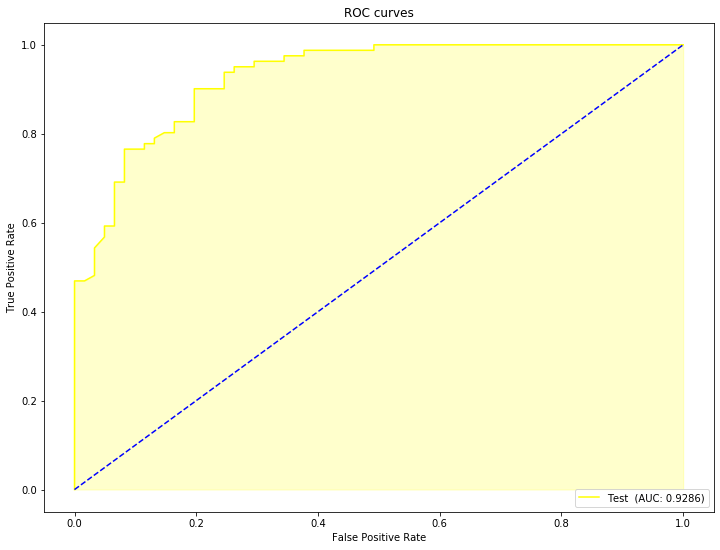

In [70]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(
                            test[feature_columns])[:, 1],
                        pos_label=1.0
                        )
df_roc_test = pd.DataFrame({"fpr": fpr,
                            "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [71]:
auc_test_model3_1 = auc_test
auc_test_model3_1

0.9285569722728192

In [72]:
auc_train_model3_1 = roc_auc_score(train3['status'],
                                 model.predict_proba(train3[feature_columns])[:, 1])
auc_train_model3_1

1.0

In [73]:
accuracy_model3_1 = accuracy_score(test['status'], model.predict(test[feature_columns]))
accuracy_model3_1

0.8450704225352113

**COMENTARIO**: Tras realizar validación cruzada, el AUC en test y en train sigue siendo similar.

Aunque parezca raro que el AUC sea tan alto, no es un problema de sobreajuste ya que se ha probado el modelo entrenando con distintos conjuntos y se ha evaluado sobre un conjunto de test con el que no se ha entrenado el modelo y aún así sale igual de alto **(al final probamos también validación cruzada repetida)**

**Evaluación del modelo: Matriz de confusión y métricas**

Hasta ahora hemos evaluado los modelos mediante el AUC, ya que es la métrica más adecuada para comparar modelos (se basa en cómo de bien clasifica el modelo para distintos umbrales). 

Sin embargo, hay otras métricas más fáciles de interpretar: las relacionadas con la matriz de confusión. Calcularemos dichas métricas sobre los datos de test para el último modelo obtenido.

Estas métricas se basan en comparar los valores reales de la variable target con los valores predichos por el modelo (estos se pueden obtener con *model.predict*). El threshold por defecto es 0.5, es decir: cuando el scoring proporcionado por el modelo es superior a 0.5, se clasifica la observación como 1 (Success). Como el dataset se ha balanceado al aplicar el modelo, un threshold de 0.5 será adecuado.

In [74]:
# valores predichos por el modelo
pred_model3_1_best = model.predict(test[feature_columns])

Calculamos la matriz de confusión sobre los datos de test a partir de los valores reales y los predichos:

In [75]:
conf_model3_1 = pd.DataFrame(confusion_matrix(test['status'], pred_model3_1_best, labels=[0, 1]),
                           index=['true: failed', 'true: success'],
                           columns=['pred: failed', 'pred: success'])
print(conf_model3_1)

               pred: failed  pred: success
true: failed             47             14
true: success             8             73


Hay 13 observaciones en test que el modelo clasifica como Success y en realidad fueron Failed, y 0 observaciones que el modelo clasificó como Failed y en realidad fueron Sucess

Ahora, calculamos las distintas métricas derivadas de esta matriz de confusión e interpretamos resultados:

In [76]:
precision_model3_1 = precision_score(test['status'], pred_model3_1_best)
recall_model3_1 = recall_score(test['status'], pred_model3_1_best)
f1_model3_1 = f1_score(test['status'], pred_model3_1_best)
accuracy_model3_1 = accuracy_score(test['status'], pred_model3_1_best)

In [77]:
precision_model3_1

0.8390804597701149

- Interpretación precision: Un 89.4% de las observaciones clasificadas como 1, realmente son 1 (de las empresas que determinamos que van a tener éxito, un 89.4% realmente lo tienen)

In [78]:
recall_model3_1

0.9012345679012346

- Interpretación recall: El modelo consigue detectar un 91.5% de las empresas que van a tener éxito (de entre todas las empresas que realmente tienen éxito, un 91.5% fueron predichas por el modelo)

In [79]:
f1_model3_1

0.8690476190476191

- Interpretación f1: compromiso entre precision y recall

In [80]:
accuracy_model3_1

0.8450704225352113

- Interpretación accuracy: El modelo acierta un 88.7% de las veces

### Modelo 3_2: Transformación PROPORTION, AUC > 0.6. RF + Grid search Repeated Cross Validation

Probamos el último modelo, pero con validación cruzada repetida

In [81]:
model3_2_rf= RandomForestClassifier(class_weight='balanced')

param_grid3_2 = {"n_estimators": [100, 200, 300, 500, 1000],  # hiperparámetros a probar (todas las combinaciones posibles)
                 "max_features": ["sqrt", 0.3, 0.6],
                 "max_depth": [None, 10, 15, 20, 30],
                 "min_samples_split": [2, 5, 10],
                 "n_jobs": [-1],
                 "class_weight": ["balanced"]
                 }


rkf3_2 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=2652124)

grid3_2 = GridSearchCV(estimator=model3_2_rf,
                     param_grid=param_grid3_2,
                     scoring="roc_auc", # métrica de evaluación: AUC
                     cv=rkf3_2, # usamos el repeated k-fold definido
                     verbose=3)

In [82]:
model3_2 = grid3_2.fit(train3[vars_selected_prop3],
                       train3['status'])  # prueba 375 modelos diferentes (5 conjuntos de entrenamiento por cada combinación del grid)

Fitting 25 folds for each of 225 candidates, totalling 5625 fits
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.936, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.991, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.955, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.949, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.959, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.968, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.944, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.985, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.968, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.981, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.938, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.949, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.957, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.931, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.989, total=   1.9s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.9s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.951, total=   1.8s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.956, total=   2.0s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_esti

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.993, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.986, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.980, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.988, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.949, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.943, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.961, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.940, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.990, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.963, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.945, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.914, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.994, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.939, total=   1.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.986, total=   1.8s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_esti

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.984, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.939, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.933, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_est

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.937, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.930, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.988, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.950, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_est

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.917, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.915, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.994, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.943, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_est

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.901, total=   1.9s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.966, total=   2.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.974, total=   1.9s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.986, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.974, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.977, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.921, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.968, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.939, total=   0.8s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.922, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.915, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.977, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.918, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.966, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.972, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.915, total=   1.8s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.954, total=   1.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.979, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.948, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=1

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.951, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.963, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.939, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.920, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.975, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.978, total=   0.8s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.909, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.968, total=   0.8s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.965, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.920, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.947, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.974, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.937, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.962, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.942, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.986, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.979, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.966, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.902, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.938, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.963, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.917, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.945, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.950, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.942, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.948, total=   1.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.8s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_esti

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.939, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.968, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.944, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.937, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.949, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.912, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.990, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.939, total=   1.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.947, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.954, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.992, total=   1.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.948, total=   1.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.985, total=   1.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.978, total=   2.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.982, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.932, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.938, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.951, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.906, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.988, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.941, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.947, total=   1.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.885, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.993, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.941, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.989, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.968, total=   2.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.981, total=   1.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.954, total=   1.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.935, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.937, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.898, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.988, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.953, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.905, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.887, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.991, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.943, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.960, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.968, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.977, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.953, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.971, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.944, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.925, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.988, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.942, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.933, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.922, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.994, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.920, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.966, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.981, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.990, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.958, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.980, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.942, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.940, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.964, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.947, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.908, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.897, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.971, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.908, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.968, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.972, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.922, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.962, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.982, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.938, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.954, total=   2.1s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.966, total=   2.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.943, total=   2.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.926, total=   2.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.978, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.968, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.908, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.955, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.961, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.912, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.956, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.975, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.941, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.953, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.965, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.951, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.984, total=   1.8s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.970, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.968, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.910, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.957, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.965, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.903, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.953, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.949, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.952, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.968, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.942, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.976, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.978, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.911, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.963, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.919, total=   2.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.951, total=   2.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.982, total=   2.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.957, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.952, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.962, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.948, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.977, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.979, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.914, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.968, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.911, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.945, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.978, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.941, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  c

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.950, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.943, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.923, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.972, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.958, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.906, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.953, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.964, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.911, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.952, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.975, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.946, total=   2.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.946, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.960, total=   1.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.943, total=   1.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.982, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.979, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.925, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.959, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.889, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.962, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.978, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.948, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.963, total=   1.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.934, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.914, total=   1.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.976, total=   2.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.977, total=   1.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.911, total=   2.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.965, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.909, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.945, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.967, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.951, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.963, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.939, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.910, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.972, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.906, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.966, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.963, total=   1.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.902, total=   1.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.944, total=   1.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.973, total=   1.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.945, total=   1.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.946, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.962, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.937, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.889, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.977, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.964, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.912, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.964, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.956, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.902, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.945, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.967, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.943, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.968, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.950, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.985, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.974, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.979, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.914, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.957, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.961, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.925, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.960, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.955, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.949, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.952, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.969, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.956, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.985, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.975, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.979, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.950, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.944, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.962, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.908, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.991, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.948, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.949, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.994, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.958, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.985, total=   1.8s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.970, total=   2.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.941, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.942, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.930, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.989, total=   0.9s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.951, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.952, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.909, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.994, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.938, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.984, total=   0.9s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.976, total=   1.8s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.984, total=   2.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.947, total=   2.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.943, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.943, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.933, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.989, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.950, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.919, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.991, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.943, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.988, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.991, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.944, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.948, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.964, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.938, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.989, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.950, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.946, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.994, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.945, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.987, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.974, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.949, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.940, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.957, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.917, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.953, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.957, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.948, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.935, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.982, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.955, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.945, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.932, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.955, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.899, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.989, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.953, total=   1.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.945, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.942, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.990, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.934, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.985, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.971, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.981, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.941, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.936, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.962, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.990, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.944, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.945, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.948, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.946, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.985, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.978, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.977, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.952, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.942, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.959, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.904, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.990, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.948, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.940, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.949, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.939, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.985, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.980, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.968, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.935, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.899, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.953, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.936, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.938, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.952, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.934, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.984, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.981, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.947, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.930, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.904, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.989, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.941, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.945, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.945, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.993, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.935, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.985, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.989, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.939, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.951, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.930, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.990, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.952, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.956, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.913, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.997, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.960, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.986, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.980, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.946, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.941, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.938, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.988, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.924, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.918, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.994, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.960, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.966, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.974, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.989, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.950, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.970, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.945, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.935, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.988, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.943, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.918, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.910, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.994, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.898, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.963, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.971, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.985, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.952, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.978, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.936, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.920, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jo

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.968, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.945, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.919, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.911, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.909, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.959, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.965, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.986, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.979, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.945, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.931, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.990, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.939, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.920, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.898, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.997, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.990, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.946, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.944, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.922, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.992, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.951, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.918, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.901, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.994, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.940, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.962, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.978, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.942, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.920, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.991, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.943, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.920, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.900, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.991, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.911, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.962, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.969, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.981, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.909, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.937, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.914, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.880, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.992, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.970, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.968, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.980, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.955, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.976, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.944, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.904, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.990, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV] 

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.909, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.885, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.992, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.940, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.965, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.950, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.937, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.910, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.990, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.948, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.947, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.879, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.986, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.942, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.987, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.959, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.984, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.948, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.925, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.942, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.899, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.991, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.944, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.900, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.887, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.991, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.941, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.956, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.972, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.989, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.938, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.938, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.991, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.941, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.926, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.912, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.992, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.917, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.968, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.972, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.991, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.946, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.983, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.938, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.938, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.966, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.945, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.919, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.901, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.978, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.902, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.970, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.978, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.913, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.947, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.980, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.945, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.948, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.966, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.952, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.923, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.974, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.965, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.907, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.961, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.918, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.952, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.978, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.939, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.957, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.966, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.948, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.970, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.978, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.916, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.966, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.908, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.944, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.979, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.945, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.950, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.969, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.942, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.916, total=   1.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.980, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.911, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.955, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.917, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.984, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.968, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.944, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.920, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.898, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.976, total=   1.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.914, total=   1.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.969, total=   1.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.906, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.954, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.932, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.947, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.948, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.923, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.974, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.963, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.907, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.966, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.957, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.914, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.944, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.974, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.944, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.946, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.936, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.978, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.968, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.914, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.973, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.910, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.946, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.976, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.947, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  c

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.945, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.962, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.937, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.914, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.913, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.966, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.942, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.972, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.948, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.902, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.965, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.940, total=   1.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.908, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.889, total=   1.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.956, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.910, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.962, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.901, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.946, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.967, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.943, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.942, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.962, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.938, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.904, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.978, total=   1.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.961, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.908, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.963, total=   1.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[Parallel(n_jobs=1)]: Done 5625 out of 5625 | elapsed: 71.9min finished


**Elección del mejor modelo**

Aquí se muestra un resumen de todos los modelos entrenados: el primero es el que tiene mayor media de AUC en los datos de validación (mean_test_score)

In [140]:
tabla = pd.DataFrame(model3_2.cv_results_).sort_values(by="mean_test_score")
tabla

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
41        0.430660      0.096720         0.111074        0.001660   
175       0.164804      0.007843         0.109958        0.000932   
85        0.280527      0.069045         0.110902        0.002171   
130       0.165037      0.007264         0.110069        0.001133   
176       0.253175      0.009124         0.109971        0.001134   
221       0.257405      0.011392         0.109788        0.001206   
88        0.795966      0.058277         0.208507        0.020243   
87        0.539774      0.087995         0.119195        0.030357   
86        0.385888      0.049516         0.110485        0.001057   
215       0.164380      0.007068         0.110148        0.001109   
131       0.253507      0.006780         0.110400        0.000814   
220       0.166108      0.007350         0.110591        0.000711   
40        0.254923      0.047296         0.111315        0.001709   
44        1.359434      0.104277         0.329236        0.047591   
223       0.556340      0.029233         0.107908        0.000882   
134       1.032058      0.019823         0.209039        0.001010   
43        0.811764      0.080168         0.217360        0.022492   
133       0.560404      0.067719         0.111635        0.019970   
89        1.431285      0.109810         0.338534        0.044605   
132       0.347149      0.014784         0.108996        0.000957   
179       1.041334      0.024739         0.214019        0.019774   
178       0.541960      0.022910         0.108181        0.001156   
222       0.342502      0.008763         0.108906        0.000924   
224       1.060039      0.053948         0.209722        0.001017   
75        0.276398      0.037894         0.111415        0.001329   
177       0.344383      0.008913         0.109205        0.001017   
30        0.296102      0.059678         0.111976        0.002336   
80        0.255714      0.069754         0.110235        0.002380   
42        0.578593      0.118888         0.114345        0.021168   
31        0.454800      0.106515         0.111855        0.001262   
205       0.157956      0.005674         0.110064        0.001021   
210       0.164634      0.008545         0.109863        0.001327   
116       0.378759      0.063536         0.110146        0.000944   
129       1.037053      0.020592         0.209372        0.001388   
145       0.148297      0.005834         0.108737        0.000407   
81        0.429458      0.087649         0.110904        0.002141   
38        0.855179      0.111535         0.212332        0.001867   
172       0.352964      0.020185         0.108457        0.001027   
125       0.254637      0.028009         0.110887        0.001278   
25        0.247317      0.056112         0.111021        0.001701   
82        0.530010      0.086884         0.110046        0.001595   
39        1.594010      0.233854         0.364132        0.084821   
128       0.546668      0.026434         0.107611        0.000823   
170       0.164688      0.005579         0.109869        0.001005   
83        0.830770      0.096343         0.201257        0.054763   
127       0.352026      0.020074         0.108034        0.000903   
115       0.248101      0.035433         0.110989        0.001713   
171       0.257799      0.014202         0.109739        0.001124   
218       0.553459      0.032057         0.112432        0.022257   
70        0.236141      0.032389         0.110690        0.001278   
174       1.047818      0.023971         0.209225        0.001064   
219       1.071105      0.054550         0.209515        0.001134   
216       0.256283      0.013078         0.109365        0.001288   
209       1.002179      0.018224         0.209572        0.001403   
217       0.365884      0.031584         0.108825        0.001266   
160       0.150064      0.005770         0.108744        0.000400   
126       3.376670      7.567392         0.359347        0.381016   
117

In [141]:
mean_test_score_modelo3_2 = tabla.iloc[0, -3]
std_test_score_modelo3_2 = tabla.iloc[0, -2]

In [159]:
model3_2_best = model3_2.best_estimator_  # mejor modelo

In [160]:
feat_importances_model3_2 = pd.DataFrame(model3_2_best.feature_importances_,
                                   index = vars_selected_prop3,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [161]:
feat_importances_model3_2

importance
number_sales_support_material                0.108463
relevance_education_venture                  0.077865
focus_structured_unstructured_data           0.069024
relevance_experience_venture                 0.067107
specialization_highest_education             0.065604
renowned_professional_circle                 0.058311
big_data_business                            0.056970
focus_functions                              0.054334
focus_private_or_public_data                 0.043212
industry_trend_investing                     0.038840
top_forums_talking_about_company             0.038568
gartner_hype_cycle_stage                     0.035645
catering_product_service_across_verticals    0.034980
B2C_or_B2B                                   0.033465
local_or_global_player                       0.031882
top_management_similarity                    0.029906
team_size_senior_lead                        0.029646
number_cofounders                            0.024642
degree_tier1_tier2_university                0.023167
aggregator_or_market_place                   0.020112
employee_benefits_salary_structures          0.020039
barriers_entry_competitors                   0.016832
predictive_analytics_business                0.012611
consulting_experience                        0.008773

**Evaluación del modelo: Curva ROC y AUC**

In [146]:
test = test3
model = model3_2_best
feature_columns = vars_selected_prop3

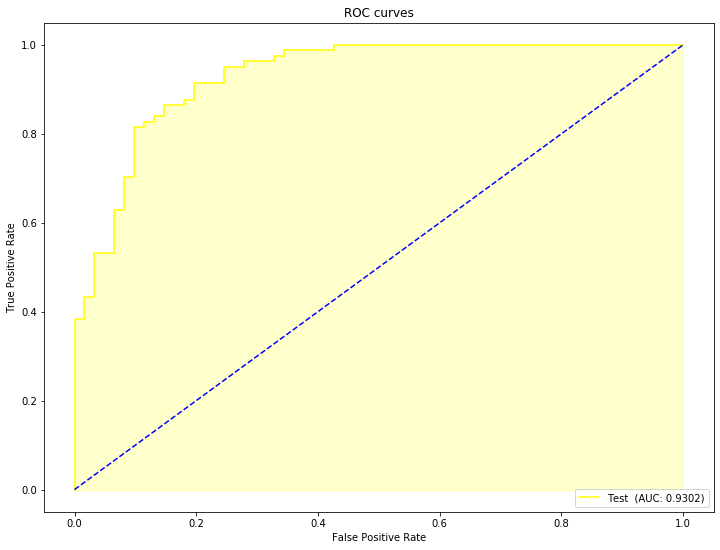

In [147]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:,1],
                        pos_label=1.0
                       )
df_roc_test = pd.DataFrame({"fpr":fpr, 
                            "tpr":tpr})

auc_test = roc_auc_score(test['status'], 
                         model.predict_proba(test[feature_columns])[:,1])

# ROC plotting
plt.figure(figsize=(12,9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"], "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0,1],[0,1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"], y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [148]:
auc_test_model_3_2 = auc_test
auc_test_model_3_2

0.9301760777170613

In [149]:
auc_train_model_3_2 = roc_auc_score(train3['status'], 
                         model.predict_proba(train3[feature_columns])[:,1])
auc_train_model_3_2

0.9983153638814016

In [150]:
accuracy_model3_2 = accuracy_score(test['status'], model.predict(test[feature_columns]))
accuracy_model3_2

0.8661971830985915

Sale similar al modelo sin validación cruzada repetida

### Modelo 5: Transformación PROPORTION, AUC>0.6. Gradient Boosting. VCR

In [93]:
df_model5 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop3]

In [94]:
model5_gb = GradientBoostingClassifier()
param = {'learning_rate': [0.1, 0.01, 0.01],
         'n_estimators': [100, 500, 1000],
         'subsample': [1, 0.8],
         'min_samples_split': [2, 5, 10],
         'max_features': ["sqrt", "log2", 0.3]}

rkf5 = RepeatedKFold(n_splits=5, n_repeats=10)

grid5 = GridSearchCV(estimator=model5_gb,
                     param_grid=param,
                     scoring="roc_auc",  # métrica de evaluación: AUC
                     cv=rkf5,
                     verbose=3)

model5 = grid5.fit(train3[vars_selected_prop3], train3['status'])

Fitting 50 folds for each of 162 candidates, totalling 8100 fits
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.985, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.936, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.969, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.968, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.922, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.931, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_fea

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.950, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.944, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.922, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.985, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.951, total=   0.1s
[CV] 

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.991, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.943, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.933, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.924, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.965, t

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.935, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.971, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.973, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.963, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.977, total=   0.4s
[CV] 

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.973, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.951, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.942, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.982, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.948, t

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.984, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.964, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.889, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.990, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.966, t

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.955, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.932, total=   0.6s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.938, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.976, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.949, total=   0

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.928, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.976, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.973, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.952, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.932, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.971, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.931, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.941, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.975, total=   0.1s
[CV] 

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.885, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.974, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.969, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.943, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.968, total=   0.1s
[CV] 

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.926, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.971, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.932, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.988, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.968, t

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.962, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.974, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.975, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.929, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.966, total=   0.4s
[CV] 

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.987, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.945, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.951, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.953, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.972, t

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.986, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.970, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.951, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.979, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.981, tot

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.975, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.946, total=   0.6s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.997, total=   0.6s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.949, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.972, total=   0

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.945, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.974, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.974, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.939, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.940, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.985, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.935, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.954, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.945, total=   0

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.970, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.939, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.974, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.987, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.928, to

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.966, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.938, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.991, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.966, total=   0.1s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.960, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.979, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.975, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.939, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.967, total=   0

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.990, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.946, total=   0.6s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.957, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.952, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.988, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.974, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.945, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.979, total=   0.4s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.947, total=   0.5s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.974, total=   0.6s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.943, total=   0.6s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.998, total=   0.6s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.953, t

[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.965, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.929, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.975, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.972, total=   0.7s
[CV] learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.939, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.968, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.934, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.943, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.934, total=   0.1s
[CV] 

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.979, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.942, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.974, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.980, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.927, total=   0.

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.970, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.940, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.980, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.961, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.974, t

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.977, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.969, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.940, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.965, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.952, total=   0.4s
[CV] 

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.956, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.968, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.959, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.973, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.986, t

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.971, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.949, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.985, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.980, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.935, total

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.954, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.997, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.952, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.980, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.932, total=   0

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.977, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.976, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.934, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.977, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.960, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.946, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.976, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.961, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.925, total=   0.1s
[CV] 

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.975, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.933, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.942, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.973, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.924, t

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.974, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.909, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.958, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.917, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.923, t

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.953, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.939, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.979, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.922, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.996, total=   0.4s
[CV] 

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.980, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.909, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.975, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.969, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.934, t

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.936, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.965, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.979, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.913, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.930, total=   0

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.929, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.969, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.954, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.929, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.980, total=   0

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.949, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.941, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.981, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.917, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.963, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.900, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.965, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.971, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.932, total=   0

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.983, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.919, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.937, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.982, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.951, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.955, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.923, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.986, total=   0.1s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.988, total=   0.3s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.914, total=   0.3s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.991, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.957, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.946, total=   0

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.902, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.968, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.976, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.940, total=   0.4s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.953, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.979, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.918, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.930, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.970, t

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.932, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.961, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.959, total=   0.5s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.940, total=   0.6s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.979, t

[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.958, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.932, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.989, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.926, total=   0.7s
[CV] learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.958, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.901, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.958, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.967, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.933, total=   0.1s
[CV] learning_

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.965, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.965, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.902, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.921, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.954, total=   0

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.946, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.933, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.984, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.946, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.878, total=   0

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.913, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.991, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.953, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.922, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.952, total=   0.4s
[CV] learning_

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.972, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.932, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.974, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.962, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.951, total=   0

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.925, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.970, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.954, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.942, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.993, total=   0.6s
[CV] 

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.990, total=   0.6s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.964, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.884, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.975, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.968, total=   0.6s
[CV] 

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.955, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.937, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.947, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.971, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.948, t

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.969, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.958, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.935, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.980, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.972, total=   0.1s
[CV] learning_

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.928, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.976, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.918, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.946, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.952, total=   0

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.972, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.976, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.941, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.979, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.981, total=   0.4s


[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.975, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.948, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.995, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.945, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.965, total=   0.4s
[CV] learning_

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.974, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.973, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.934, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.972, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.963, total=   0

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.932, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.957, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.959, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.975, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.975, total=   0.6s
[CV] 

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.944, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.966, total=   0.6s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.985, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.938, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.957, total= 

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.949, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.997, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.949, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.966, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.932, t

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.971, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.930, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.963, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.938, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.929, total=   0.1s
[CV] 

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.947, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.969, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.960, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.901, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.963, t

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.971, total=   0.1s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.976, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.935, total=   0.3s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.955, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.975, total=   0.4s
[CV

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.947, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.956, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.929, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.954, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.950, total=   0.4s
[CV] 

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.968, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.966, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.932, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.978, total=   0.4s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.924, t

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.971, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.978, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.895, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.972, total=   0.5s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.960, total=   0

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.933, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.961, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.985, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.919, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.965, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.932, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.960, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.959, total=   0.7s
[CV] learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.1, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.917, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.935, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.982, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.900, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.977, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.902, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.944, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.984, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.920, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.963, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.971, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.907, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.934, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.954, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.953, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.939, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.933, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.982, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.942, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.934, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.985, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.900, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.986, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.963, total=   0.8s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.896, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.971, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.970, total=   0.8s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.928, t

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.933, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.954, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.971, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.912, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.982, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.920, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.953, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.951, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.929, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.932, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.985, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.895, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.979, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.926, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.897, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.945, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.978, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.928, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.961, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.968, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.911, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.934, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.918, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.953, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.937, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.933, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.984, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.933, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.925, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.983, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.899, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.972, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.961, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.903, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.967, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.970, t

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.984, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.931, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.958, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.970, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.961, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.978, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.915, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.955, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.925, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.950, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.983, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.898, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.978, t

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.929, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.897, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.946, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.980, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.929, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.959, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.971, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.907, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.934, t

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.980, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.910, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.959, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.941, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.919, t

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.967, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.935, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.931, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.986, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.946, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.971, total=   0.8s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.961, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.888, total=   0.8s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.973, total=   0.8s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.982, total=   1.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.932, total=   1.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.959, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subs

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.937, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.993, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.958, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.981, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, su

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.956, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.904, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.977, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.915, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.921, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.963, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.934, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.896, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.942, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.980, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.928, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.958, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.973, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.903, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.973, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.917, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.955, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.947, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.922, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.969, total=   0.5s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.930, total=   0.5s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.932, total=   0.5s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.987, total=   0.5s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.943, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.975, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.962, total=   0.8s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.907, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.965, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.976, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.984, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.934, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.961, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.993, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.955, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.976, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.924, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.961, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.918, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.972, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.929, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.949, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.947, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.953, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.932, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.894, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.978, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.929, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.963, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.973, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.906, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.981, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.917, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.951, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.942, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.928, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.969, total=   0.5s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.934, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.917, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.987, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.947, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.975, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.961, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.899, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.969, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.974, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.984, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.932, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.953, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.992, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.960, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.979, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.918, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.959, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.922, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.980, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.921, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.936, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.942, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.956, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.933, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.900, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.979, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.928, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.951, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.967, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.909, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.958, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.978, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.910, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.955, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.943, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.922, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.966, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.929, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.920, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.953, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.942, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.973, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.961, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.937, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.977, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.984, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.928, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsampl

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.973, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.937, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.994, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.962, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, su

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.933, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.975, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.963, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.908, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.972, total=   0.1s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.969, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.922, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.900, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.944, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.979, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.976, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.929, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.961, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.971, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.912, total=   0.4s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.974, total=   0.3s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.929, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.948, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.947, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.922, total=   0.3s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.935, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.927, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.986, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.905, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.985, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.962, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.895, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.970, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.968, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.931, total=   0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.957, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.970, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.916, total=   0.8s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.937, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.921, total=   0.6s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.952, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.950, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.920, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.941, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.980, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.893, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.972, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.925, total=   0.1s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.887, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.939, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.980, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.922, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.981, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.962, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.972, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.904, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.926, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.955, total=   0.3s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.953, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.945, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.933, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.985, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.948, total=   0.4s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.987, total=   0.3s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.909, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.985, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.944, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.953, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.974, total=   0.7s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.971, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.927, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.975, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.965, total=   0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.907, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.935, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.959, total=   0.7s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.944, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.949, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.931, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.989, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.948, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.973, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.922, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.946, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.919, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.951, total=   0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.920, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.941, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.964, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.956, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.943, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.928, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.979, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.942, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.965, total=   0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.891, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.971, total=   0.3s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.965, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.933, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.975, total=   0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.946, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.929, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.958, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.938, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.975, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.963, total=   0.7s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.930, total=   0.6s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.974, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.970, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.960, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.945, total=   0.6s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.938, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.979, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.980, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.944, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.885, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.973, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.921, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.953, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.935, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.979, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=1, score=0.952, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.965, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.969, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.958, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.917, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.934, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.975, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.947, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.964, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.938, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.974, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.978, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.938, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=1, score=0.972, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.980, total=

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.923, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.957, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.946, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.989, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.969, total=   0.3s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.934, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.977, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.969, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=1, score=0.926, t

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.936, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.934, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.981, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.948, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.950, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.881, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.978, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.970, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=2, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.938, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.979, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.947, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.971, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=1, score=0.912, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.913, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.972, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.929, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.941, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.963, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.945, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.970, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.947, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.898, total=   0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=1, score=0.975, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.980, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.924, total=   0.3s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.963, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.991, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.958, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.978, total=   0.3s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.913, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.969, total=   0.3s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.926, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.967, total=   0.6s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.947, total=   0.7s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=1, score=0.932, t

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.941, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.948, total=   0.8s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.952, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.972, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.970, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.939, total=   0.6s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.978, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.981, total=   0.1s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, scor

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.969, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.950, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.966, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.903, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=1, score=0.956, t

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.919, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.981, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.895, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.980, total=   0.0s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=100, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.945, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.909, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.961, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.972, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=1, score=0.920, t

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.921, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.962, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.971, total=   0.3s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.905, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.978, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.912, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.952, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.943, total=   0.2s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=500, subsample=0

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.966, total=   0.3s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.945, total=   0.3s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.934, total=   0.3s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score=0.985, total=   0.5s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=1, score

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.950, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.970, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.959, total=   0.4s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.905, total=   0.8s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, su

[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.938, total=   0.9s
[CV] learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=sqrt, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.977, total=   0.5s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.975, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.928, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.969

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.951, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.972, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.913, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.961, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=1, score=0.947, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.914, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.974, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.928, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.934, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.969, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.942, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.968, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.946, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=1, score=0.907, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.980, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.924, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.961, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.966, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.958, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.974, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.912, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.958, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.928, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.964, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.942, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.927, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=1, score=0.984, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.952, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.950, total=   0.5s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.975, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.955, total=   0.6s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.939, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.975, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.972, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.933, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.961, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.908, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.956, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.947, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.916, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=1, score=0.971, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.926, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.936, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.979, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.893, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.971, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.949, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.908, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.961, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=1, score=0.975, total=   0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.927, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.957, total=   0.5s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.966, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.898, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.975, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.907, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.957, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.944, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.964, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.945, total=   0.6s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.931, total=   0.8s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.982, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=1, score=0.908, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.948, total=   0.9s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.972, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.959, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.908, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.973, total=   0.8s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.973, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.931, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.964, total=   0.1s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.964,

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.973, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.954, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.970, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.908, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=1, score=0.962, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.934, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.979, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.898, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.974, total=   0.0s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=100, subsample=0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.947, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.903, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.961, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.972, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=1, score=0.924, t

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.925, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.961, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.971, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.904, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.979, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.905, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.957, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.942, total=   0.2s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=500, subsample=0

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.963, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.945, total=   0.3s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.935, total=   0.3s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score=0.985, total=   0.3s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=1, score

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.955, total=   0.6s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.971, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.958, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.898, total=   0.6s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, su

[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.945, total=   0.4s
[CV] learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=log2, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.973, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.971, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.933, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.964, tota

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.971, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.951, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.972, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.909, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=1, score=0.957, total=   0.1s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.982, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.925, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.938, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.981, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=100, subsample=0.8, score=0.892, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.945, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.904, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.958, total=   0.3s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.971, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=1, score=0.922, total=   0.4s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.961, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.975, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.898, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.933, total=   0.3s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.958, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.909, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.951, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.948, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.931, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=500, subsample=0.8, score=0.982, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.935, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.984, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.907, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.992, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=1, score=0.955, total=   0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.954, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.893, total=   0.8s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.964, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score=0.970, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=2, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.956, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.972, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.902, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.926, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.965, total=   0.1s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.929, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.929, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.973, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.931, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=1, score=0.884, total=   0.1s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.957, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.899, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.954, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.935, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=100, subsample=0.8, score=0.972, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.932, total=   0.3s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.972, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.962, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.918, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=1, score=0.966, total=   0.3s
[CV] 

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.974, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.948, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.964, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.943, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.971, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.977, total=   0.3s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.972, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.933, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=500, subsample=0.8, score=0.976, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.978, tot

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.967, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.945, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.993, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.961, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=1, score=0.975, total=   0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.934, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.975, total=   0.7s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.969, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score=0.922, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=5, n_estimators=1000, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.970, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.930, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.979, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.945, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=1, score=0.968, total=   0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.972, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.939, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.967, total=   0.1s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.967, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.941, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.971, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.905, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score=0.953, total=   0.0s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=100, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.927, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.926, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.983, total=   0.2s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.903, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=1, score=0.986, total=   0

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.970, total=   0.8s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.945, total=   0.6s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.906, total=   0.6s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score=0.962, total=   0.6s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=500, subsample=0.8, score

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.975, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.932, total=   0.8s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.960, total=   0.6s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.971, total=   0.8s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.916, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.960, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.969, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.927, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.951, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=1, score=0.947, t

[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.923, total=   0.4s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.966, total=   0.5s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.944, total=   0.6s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8, score=0.934, total=   0.9s
[CV] learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_features=0.3, min_samples_split=10, n_estimators=1000, subsample=0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 8100 out of 8100 | elapsed: 76.5min finished


In [177]:
tabla = pd.DataFrame(model5.cv_results_).sort_values(by="mean_test_score", ascending=False)
tabla

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
21        0.445911      0.006849         0.004460        0.000480   
27        0.436148      0.006219         0.004331        0.000471   
29        0.716618      0.025802         0.004975        0.000431   
15        0.435636      0.030664         0.004616        0.000742   
23        0.715814      0.013184         0.004928        0.000427   
11        0.708694      0.018774         0.004848        0.000347   
9         0.440594      0.019352         0.004460        0.000568   
33        0.429353      0.015424         0.004622        0.000668   
41        0.729705      0.069649         0.004855        0.000802   
45        0.447707      0.009363         0.004436        0.000491   
5         0.708943      0.015826         0.004829        0.000364   
3         0.473936      0.079589         0.004415        0.000532   
20        0.368880      0.005837         0.004441        0.000492   
39        0.457122      0.012534         0.004483        0.000499   
26        0.359745      0.005576         0.004594        0.000530   
35        0.706621      0.017377         0.004854        0.000448   
22        0.547802      0.016471         0.004788        0.000447   
4         0.546997      0.022991         0.004926        0.000703   
53        0.698511      0.017513         0.004717        0.000559   
38        0.376119      0.012107         0.004371        0.000526   
2         0.375233      0.026521         0.004468        0.000568   
8         0.360403      0.006057         0.004355        0.000477   
40        0.537015      0.017506         0.004709        0.000445   
17        0.721418      0.034904         0.005051        0.000573   
10        0.548804      0.026021         0.004922        0.000507   
47        0.691791      0.014856         0.004688        0.000457   
51        0.436750      0.007378         0.004493        0.000502   
28        0.550249      0.035307         0.004911        0.000349   
34        0.538961      0.016419         0.004978        0.000321   
32        0.352033      0.009930         0.004475        0.000575   
14        0.354475      0.007923         0.004531        0.000496   
46        0.530624      0.017249         0.004647        0.000473   
16        0.570321      0.068039         0.004970        0.000675   
131       0.577248      0.182378         0.004073        0.001607   
50        0.360094      0.012214         0.004452        0.000494   
137       0.564125      0.181152         0.003934        0.001448   
83        0.865877      0.011384         0.005759        0.000459   
119       0.573385      0.183871         0.003940        0.001516   
143       0.556119      0.179952         0.003770        0.001297   
71        0.868855      0.039510         0.005975        0.000925   
12        0.075150      0.002577         0.003413        0.000521   
44        0.375397      0.016305         0.004422        0.000488   
94        0.511026      0.158978         0.003823        0.001404   
130       0.482318      0.161725         0.004044        0.001248   
155       0.600481      0.189564         0.004082        0.001643   
77        0.892458      0.008397         0.005834        0.000614   
148       0.508189      0.167979         0.003971        0.001481   
59        0.886825      0.009524         0.005958        0.000453   
154       0.481697      0.162658         0.003697        0.001271   
89        0.804109      0.132357         0.005524        0.001001   
101       0.595774      0.189734         0.003955        0.001451   
124       0.459317      0.150038         0.003952        0.001469   
118       0.472291      0.154526         0.003807        0.001468   
65        0.871859      0.012093         0.005935        0.000562   
125       0.563766      0.183334         0.003789        0.001475   
52        0.523315      0.016954         0.004727        0.000433   
58        0.737316      0.015067         0.005869        0.000430   
142

In [96]:
mean_test_score_modelo5 = tabla.iloc[0, -3]
std_test_score_modelo5 = tabla.iloc[0, -2]

In [179]:
model5_2 = model5.best_estimator_  # mejor modelo

**Importancia de variables**

In [180]:
feat_importances_model5 = pd.DataFrame(model5_2.feature_importances_,
                                       index=vars_selected_prop3,
                                       columns=['importance']).sort_values('importance', ascending=False)
feat_importances_model5

importance
number_sales_support_material                0.169725
renowned_professional_circle                 0.104026
relevance_education_venture                  0.086927
focus_functions                              0.077608
relevance_experience_venture                 0.064151
focus_structured_unstructured_data           0.059599
specialization_highest_education             0.054946
top_forums_talking_about_company             0.041417
big_data_business                            0.041307
local_or_global_player                       0.039579
industry_trend_investing                     0.033791
catering_product_service_across_verticals    0.028526
gartner_hype_cycle_stage                     0.025677
barriers_entry_competitors                   0.025667
focus_private_or_public_data                 0.024589
B2C_or_B2B                                   0.022851
team_size_senior_lead                        0.019835
employee_benefits_salary_structures          0.015772
aggregator_or_market_place                   0.015015
number_cofounders                            0.015010
degree_tier1_tier2_university                0.013828
top_management_similarity                    0.013545
predictive_analytics_business                0.004765
consulting_experience                        0.001843

**Validaciones y métricas**

In [181]:
test = test3
model = model5_2
feature_columns = vars_selected_prop3

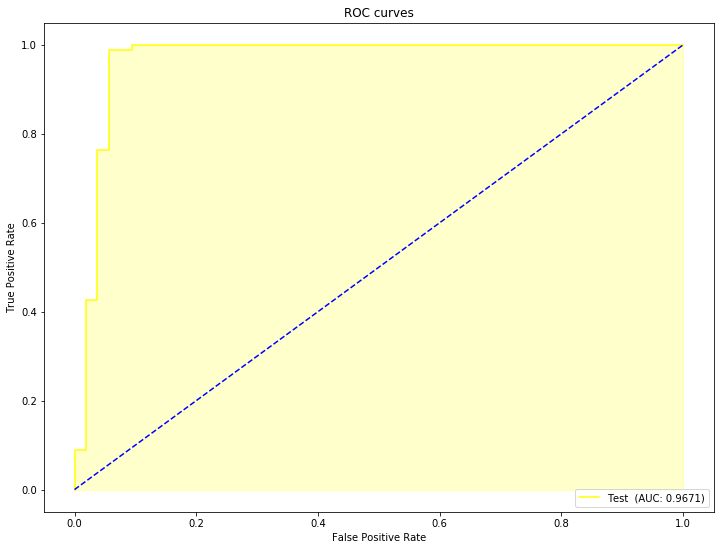

In [182]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(
                            test[feature_columns])[:, 1],
                        pos_label=1.0
                        )
df_roc_test = pd.DataFrame({"fpr": fpr,
                            "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [183]:
auc_test_model5 = auc_test
auc_test

0.9671401314394743

In [184]:
auc_train_model5 = roc_auc_score(train3['status'], 
                         model.predict_proba(train3[feature_columns])[:,1])
auc_train_model5

0.989319363222872

In [185]:
# Valores predichos, punto de corte 0.64
probab = model5_2.predict_proba(test[feature_columns])[:,1]
map_iterator = map(lambda x: 1 if x >= 0.64 else 0, probab)
pred_model5 = list(map_iterator)

In [186]:
conf_model5 = pd.DataFrame(confusion_matrix(test['status'], pred_model5, labels=[0, 1]),
                           index=['true: failed', 'true: success'],
                           columns=['pred: failed', 'pred: success'])
print(conf_model5)

               pred: failed  pred: success
true: failed             48              5
true: success             0             89


In [187]:
precision_model5 = precision_score(test['status'], pred_model5) # Precisión en la detección de Success
precision_model5

0.9468085106382979

In [188]:
recall_model5 = recall_score(test['status'], pred_model5) # Capacidad de detectar Success
recall_model5

1.0

In [189]:
f1_model5 = f1_score(test['status'], pred_model5) # Compromiso entre precisión y recall
f1_model5

0.9726775956284154

In [190]:
accuracy_model5 = accuracy_score(test['status'], pred_model5) # Tasa de acierto
accuracy_model5

0.9647887323943662

## 5. Resumen de modelos

Se crea una tabla resumen con todos los modelos contruidos

In [191]:
modelos = ["RF_Freq_1", "RF_Prop_1", "RF_Prop_2", "RF_Prop_2_VC", "RF_Prop_2_VCR", "GBoost_Prop_VCR"]
aucTest = [auc_test_model1, auc_test_model2, auc_test_model3, auc_test_model3_1, auc_test_model_3_2, auc_test_model5]
meanAucTrain = [auc_train_model1, auc_train_model2, auc_test_model3, mean_test_score_modelo3_1, mean_test_score_modelo3_2, mean_test_score_modelo5]
stdAucTrain = [0, 0, 0, std_test_score_modelo3_1, std_test_score_modelo3_2, std_test_score_modelo5]
accuracy = [accuracy_model1, accuracy_model2, accuracy_model3, accuracy_model3_1, accuracy_model3_2, accuracy_model5]

In [192]:
pd.DataFrame({'modelos': modelos, 'aucTest': aucTest, 'meanAucTrain': meanAucTrain, 'stdAucTrain': stdAucTrain, 'accuracy': accuracy}, 
                  columns=['modelos', 'aucTest', 'meanAucTrain', 'stdAucTrain', 'accuracy'])

modelos   aucTest  meanAucTrain  stdAucTrain  accuracy
0        RF_Freq_1  0.916987      0.999939     0.000000  0.809859
1        RF_Prop_1  0.903846      1.000000     0.000000  0.845070
2        RF_Prop_2  0.916515      0.916515     0.000000  0.852113
3     RF_Prop_2_VC  0.928557      0.964398     0.017770  0.845070
4    RF_Prop_2_VCR  0.930176      0.944668     0.029699  0.866197
5  GBoost_Prop_VCR  0.967140      0.959379     0.023819  0.964789

In [194]:
metricas = ["precision", "recall", "f1", "accuracy"]
modeloGB = [precision_model5, recall_model5, f1_model5, accuracy_model5]

pd.DataFrame({'metricas': metricas, 'modeloGB': modeloGB}, 
                  columns=['metricas', 'modeloGB'])

metricas  modeloGB
0  precision  0.946809
1     recall  1.000000
2         f1  0.972678
3   accuracy  0.964789